### Generating Global embedding

In [2]:
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import sklearn.linear_model as LinearModels

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pandas as pd
from tqdm import *
from scipy import stats

from pathlib import Path

NathanPath="d:\Documents\Info\INF554\INF554_Kaggle_Project"
NathanPath="/users/eleves-a/2019/nathan.peluso/INF554/INF554_Kaggle_Project"

project_path = str(Path(os.getcwd()).parent.absolute())
print("Current directory : " + os.getcwd() + ", Project directory : " + project_path)

os.chdir(project_path)
os.chdir(NathanPath)

Current directory : /users/eleves-a/2019/nathan.peluso/INF554/INF554_Kaggle_Project/Global, Project directory : /users/eleves-a/2019/nathan.peluso/INF554/INF554_Kaggle_Project


In [56]:
vectors=np.load("Global/paper_vectors.npy")

In [57]:
id_abstracts=vectors[:,0].astype(np.int64)

In [58]:
print(len(id_abstracts))
print(np.max(id_abstracts))
print(np.min(id_abstracts))

624181
2908511069
3603


In [59]:
num_id_abstracts=dict([(a,b) for a,b in enumerate(id_abstracts)])
id_abstracts_num=dict([(b,a) for a,b in enumerate(id_abstracts)])

In [65]:
len(id_abstracts_num.keys())

624181

In [60]:
with open("data/author_papers.txt") as f:
    authors_papers=f.readlines()

In [61]:
n_dim=vectors.shape[1]-1
authors_vectors=np.zeros((len(authors_papers), n_dim+1), dtype=np.float64)

In [68]:
papers=authors_papers[0].split("\n")[0].split(":")[1].split("-")
print(papers)
p=papers[0]
print(int(p))
print(id_abstracts_num.get(int(p)))

['1510273386', '1827736641', '1588673897', '2252711322', '2123653597']
1510273386
58046


In [78]:
s=0
for i,author in enumerate(authors_papers):
    papers=author.split("\n")[0].split(":")[1].split("-")
    vector=np.zeros(n_dim)
    no_fail=False
    for p in papers:
        try:
            vector+=vectors[id_abstracts_num[int(p)], 1:]
            no_fail=True
        except KeyError:
            pass
    if (not no_fail):
        s+=1
    authors_vectors[i][0]=int(author.split(":")[0])
    if (np.linalg.norm(vector)>0):
        vector=vector/np.linalg.norm(vector)
    authors_vectors[i][1:]=vector.copy()
print(s)


1880


In [79]:
np.save("Global/authors_vectors.npy", authors_vectors)

## Concatenate

In [69]:
embeddings_improved=np.load("DeepWalk/embeddings_improved.npy")
authors_vectors=np.load("Global/authors_vectors.npy")
G = nx.read_edgelist('data/coauthorship.edgelist', delimiter=' ', nodetype=int)

In [70]:
embeddings_improved.shape

(217801, 135)

In [92]:
print(embeddings_improved.shape)
print(authors_vectors.shape)

auth_vec_num_id_author=dict([(a,b) for a,b in enumerate(authors_vectors[:,0])])
id_author_auth_vec_num=dict([(b,a) for a,b in enumerate(authors_vectors[:,0])])

graph_num_id_author=dict([(a,b) for a,b in enumerate(G.nodes)])
id_author_graph_num=dict([(b,a) for a,b in enumerate(G.nodes)])

emb_num_id_author=dict([(a,int(b)) for a,b in enumerate(embeddings_improved[:,0])])
id_author_emb_num=dict([(int(b),a) for a,b in enumerate(embeddings_improved[:,0])])

(217801, 135)
(217801, 151)


In [95]:
n_nodes=G.number_of_nodes()
n_emb=embeddings_improved.shape[1]-1
n_abs=authors_vectors.shape[1]-1
n_dim_tot=1+n_emb+n_abs
full_matrix=np.zeros((n_nodes, n_dim_tot), dtype=np.float64)
for i in range(n_nodes):
    node=graph_num_id_author[i]
    full_matrix[i,0]=node
    full_matrix[i,1:1+n_emb]=embeddings_improved[id_author_emb_num[node],1:].copy()
    full_matrix[i,1+n_emb:]=authors_vectors[id_author_auth_vec_num[node],1:].copy()



In [96]:
np.save("Global/full_embedding_matrix.npy", full_matrix)

In [58]:
full_matrix.shape

(217801, 285)

## MLP

In [97]:
class MLP(nn.Module):
    """Simple MLP model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, dropout):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        z0 = self.relu(self.fc1(x))
        z0 = self.dropout(z0)
        z1 = self.relu(self.fc2(z0))
        out = self.fc3(z1)
        return out

In [98]:
def MSE(X,Y):
    if (len(X)!=len(Y)):
        print("Sizes not identical")
        return -1
    return (X-Y)@(X-Y) / len(X)

## Sets

In [99]:
G = nx.read_edgelist('data/coauthorship.edgelist', delimiter=' ', nodetype=int)
df_train = pd.read_csv('data/train.csv', dtype={'author': np.int64, 'hindex': np.float32})
df_test = pd.read_csv('data/test.csv', dtype={'author': np.int64})
full_embedding=np.load("Global/full_embedding_matrix.npy")

In [100]:
abs_nodeID_Train=dict(df_train["author"])
nodeID_abs_Train=dict([(b,a) for a,b in abs_nodeID_Train.items()])

abs_nodeID_Test=dict(df_test["author"])
nodeID_abs_Test=dict([(b,a) for a,b in abs_nodeID_Test.items()])

abs_hindex_Train=dict(df_train["hindex"])

abs_nodeID_Graph=dict(enumerate(G.nodes))
nodeID_abs_Graph=dict([(b,a) for a,b in enumerate(G.nodes)])

n=G.number_of_nodes()
n_train=abs_nodeID_Train.__len__()
n_test=abs_nodeID_Test.__len__()

In [101]:
#Careful, those indexes are related to the TRAIN set, not to the global graph indexing
idx=np.random.permutation(n_train)
idx_train=idx[:int(0.8*n_train)]
idx_val=idx[int(0.8*n_train):]

nodes_train=[abs_nodeID_Train[i] for i in idx_train]
nodes_val=[abs_nodeID_Train[i] for i in idx_val]

X_train_x = torch.tensor([full_embedding[nodeID_abs_Graph[node]][1:] for node in nodes_train], dtype=torch.float32)
X_val_x = torch.tensor([full_embedding[nodeID_abs_Graph[node]][1:] for node in nodes_val], dtype=torch.float32)

hindex_train_x=torch.tensor([abs_hindex_Train[i] for i in idx_train], dtype=torch.float32)
hindex_val_x=torch.tensor([abs_hindex_Train[i] for i in idx_val], dtype=torch.float32)

## MLP Training on split set

In [ ]:
n_dim=X_train_x.shape[1]
model=MLP(n_dim,256,64,0.3)

loss_vals=[]
loss_trains=[]

In [113]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_x)
    loss_train = loss(output.reshape(-1), hindex_train_x)
    loss_trains.append(loss_train.item())
    loss_train.backward()
    optimizer.step()

    model.eval()
    output= model(X_val_x)

    loss_val = loss(output.reshape(-1), hindex_val_x)
    loss_vals.append(loss_val.item())
    print('Epoch: {:03d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()))
    if (epoch>100 and loss_val.item()>loss_train.item()*1.1):
        break

Epoch: 001 loss_train: 129.9395 loss_val: 75.9737
Epoch: 002 loss_train: 84.2800 loss_val: 81.0137
Epoch: 003 loss_train: 85.8534 loss_val: 83.6312
Epoch: 004 loss_train: 86.0053 loss_val: 84.3926
Epoch: 005 loss_train: 82.9849 loss_val: 86.9541
Epoch: 006 loss_train: 82.0464 loss_val: 85.3234
Epoch: 007 loss_train: 81.3070 loss_val: 80.0291
Epoch: 008 loss_train: 77.5318 loss_val: 74.9453
Epoch: 009 loss_train: 74.7539 loss_val: 72.6639
Epoch: 010 loss_train: 75.8380 loss_val: 72.4747
Epoch: 011 loss_train: 77.9883 loss_val: 71.6868
Epoch: 012 loss_train: 78.7933 loss_val: 69.6541
Epoch: 013 loss_train: 77.9094 loss_val: 69.6241
Epoch: 014 loss_train: 74.9831 loss_val: 72.4308
Epoch: 015 loss_train: 73.3754 loss_val: 76.1548
Epoch: 016 loss_train: 75.8551 loss_val: 77.7035
Epoch: 017 loss_train: 76.1453 loss_val: 76.0124
Epoch: 018 loss_train: 74.7386 loss_val: 72.6891
Epoch: 019 loss_train: 72.4096 loss_val: 70.0062
Epoch: 020 loss_train: 72.1020 loss_val: 68.9886
Epoch: 021 loss_tra

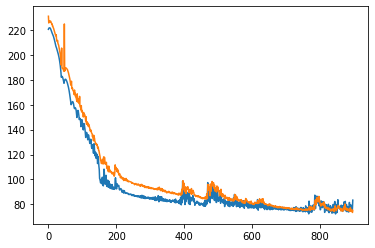

In [108]:
plt.plot(loss_vals[20:])
plt.plot(loss_trains[20:])

In [109]:
torch.save(model.state_dict(), "Global/256_64_1.pt")

## MLP Submission


In [119]:
full_embedding_glob=np.load("Global/full_embedding_matrix.npy")
X_train_glob = torch.tensor([full_embedding_glob[nodeID_abs_Graph[node]][1:]for node in nodeID_abs_Train.keys()], dtype=torch.float32)
hindex_train_glob=torch.tensor([abs_hindex_Train[nodeID_abs_Train[node]] for node in nodeID_abs_Train.keys()], dtype=torch.float32)
X_test=torch.tensor([full_embedding_glob[nodeID_abs_Graph[node]][1:] for node in nodeID_abs_Test.keys()], dtype=torch.float32)


idx=range(n_train)
nodes_train=[abs_nodeID_Train[i] for i in idx]
X_train_glob = torch.tensor([full_embedding_glob[nodeID_abs_Graph[node]][1:] for node in nodes_train], dtype=torch.float32)
hindex_train_glob=torch.tensor([abs_hindex_Train[i] for i in idx], dtype=torch.float32)

X_test_glob = torch.tensor([full_embedding_glob[nodeID_abs_Graph[node]][1:] for node in nodeID_abs_Test.keys()], dtype=torch.float32)

In [121]:
n_dim=X_train_x.shape[1]
model_glob=MLP(n_dim,256,64,0.3)

loss_trains_glob=[]
loss = nn.MSELoss()
lr=1e-2
for i in range(5):
    lr/=2
    optimizer = optim.Adam(model_glob.parameters(), lr=lr)
    for epoch in range(200):
        model_glob.train()
        optimizer.zero_grad()
        output = model_glob(X_train_glob)
        loss_train_glob = loss(output.reshape(-1), hindex_train_glob)
        loss_trains_glob.append(loss_train_glob.item())
        loss_train_glob.backward()
        optimizer.step()
        print('Epoch: {:03d}'.format(epoch+1),
                'loss_train: {:.4f}'.format(loss_train_glob.item()))

Epoch: 001 loss_train: 24992.8770
Epoch: 002 loss_train: 4594351104.0000
Epoch: 003 loss_train: 1537301120.0000
Epoch: 004 loss_train: 10861291.0000
Epoch: 005 loss_train: 18185912.0000
Epoch: 006 loss_train: 6824299.0000
Epoch: 007 loss_train: 141065.9219
Epoch: 008 loss_train: 2137109.2500
Epoch: 009 loss_train: 3920088.2500
Epoch: 010 loss_train: 3980178.5000
Epoch: 011 loss_train: 3192298.7500
Epoch: 012 loss_train: 2431263.2500
Epoch: 013 loss_train: 1826765.0000
Epoch: 014 loss_train: 1012823.1250
Epoch: 015 loss_train: 194875.3125
Epoch: 016 loss_train: 939968.6250
Epoch: 017 loss_train: 338878.2500
Epoch: 018 loss_train: 77190.0234
Epoch: 019 loss_train: 44419.0820
Epoch: 020 loss_train: 10778.8438
Epoch: 021 loss_train: 508.9709
Epoch: 022 loss_train: 9601.0850
Epoch: 023 loss_train: 25949.4609
Epoch: 024 loss_train: 35835.5195
Epoch: 025 loss_train: 43942.3984
Epoch: 026 loss_train: 45779.9141
Epoch: 027 loss_train: 44790.4258
Epoch: 028 loss_train: 43212.3984
Epoch: 029 loss

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_trains_glob)

In [ ]:
torch.save(model_glob.state_dict(), "Global/full_train_model_1.pt")